# Linear regression

We want to use linear regression to predict if the asset price on the next time step will be greater of lower than the current one, in order to take a long or short trading position.

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

In [44]:
ticker = 'EURUSD=X'
start = '2010-10-10'
end = '2024-10-10'
interval = '1d'
df = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [45]:
df['logRet'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df['logRet1'] = df['logRet'].shift(1)

In [46]:
# With logRet and logRet1, we will have in the same row the logRet of time t and logRet of time t-1
df

,Adj Close,logRet,logRet1
Date,,,
2010-10-11,1.397761,NaN,NaN
2010-10-12,1.388021,-0.006992,NaN
2010-10-13,1.391692,0.002641,-0.006992
2010-10-14,1.396726,0.003611,0.002641
2010-10-15,1.407202,0.007472,0.003611
...,...,...,...
2024-04-18,1.066940,0.004503,-0.000404
2024-04-19,1.064419,-0.002366,0.004503
2024-04-22,1.065825,0.001321,-0.002366


In [47]:
df.dropna(inplace=True)

<Axes: xlabel='logRet1', ylabel='logRet'>

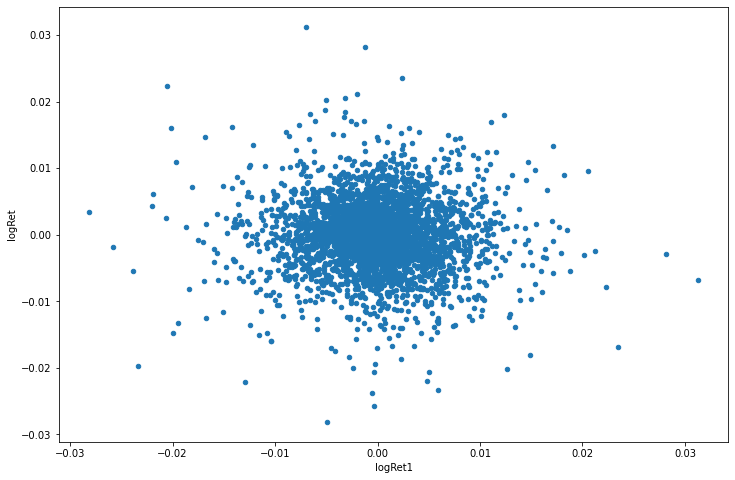

In [48]:
df.plot(kind='scatter', x='logRet1', y='logRet', figsize=(12,8))

We want to predict the return of the next time step (1day in our case), using the return of the previous time step. For this reason we plot on the x-axis the logRet1 (is return a time t-1) and logRet (return at time t). The plot look like a cloud, so we could think that there is not a relationship between the two. We will try to use linear regression to find it.

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X=df.logRet1.to_frame(), y=df.logRet.to_frame())

LinearRegression()

If the coefficient is equal zero, it means that there is no relationship between logRet and logRet1 so it is not possible to use one to predict the other. But in this case we have coef_ = -0.032, this means that if logRet1 has a variation of 100%, logRet will have a variation of -3.2%, so we would take a short position. Yes, I know it's a very small relationship.

In [52]:
print(lm.coef_)
slope = float(lm.coef_)

[[-0.03204749]]


In [53]:
intercept = float(lm.intercept_)

In [54]:
df['predict'] = lm.predict(df.logRet1.to_frame())

<Axes: xlabel='Date'>

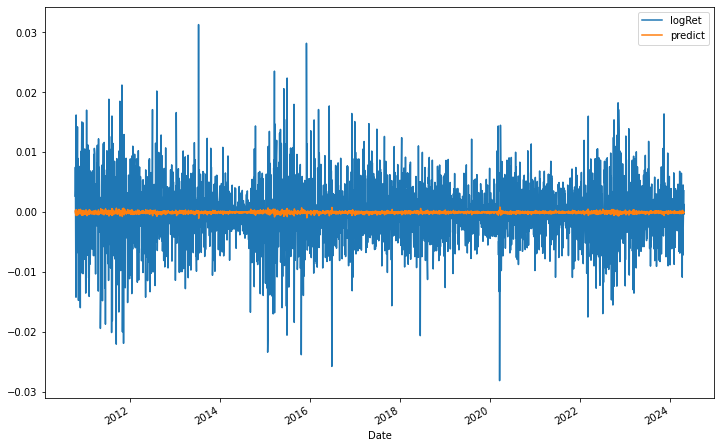

In [55]:
df[['logRet','predict']].plot(figsize=(12,8))

#### With this model, we don't really want to predict the logReturn of the next time step, but we want to predict if it will be positive or negative. In this way we can take a log or short position. 

In [57]:
df['position'] = np.sign(df['predict'])

In [58]:
df

,Adj Close,logRet,logRet1,predict,position
Date,,,,,
2010-10-13,1.391692,0.002641,-0.006992,1.475971e-04,1.0
2010-10-14,1.396726,0.003611,0.002641,-1.611152e-04,-1.0
2010-10-15,1.407202,0.007472,0.003611,-1.922095e-04,-1.0
2010-10-18,1.396433,-0.007682,0.007472,-3.159587e-04,-1.0
2010-10-19,1.393592,-0.002037,-0.007682,1.696979e-04,1.0
...,...,...,...,...,...
2024-04-18,1.066940,0.004503,-0.000404,-6.355167e-05,-1.0
2024-04-19,1.064419,-0.002366,0.004503,-2.207972e-04,-1.0
2024-04-22,1.065825,0.001321,-0.002366,-6.660838e-07,-1.0


Now we can compute how many time our prevision was right (hit). To do so we must check that the sign for logRet and position in each row is the same.

In [61]:
hits = np.sign(df.position * df.logRet)
hits.value_counts()
# +1 is when our prediction was right, -1 when it was wrong

 1.0    1797
-1.0    1710
 0.0      19
Name: count, dtype: int64

<Axes: xlabel='Date'>

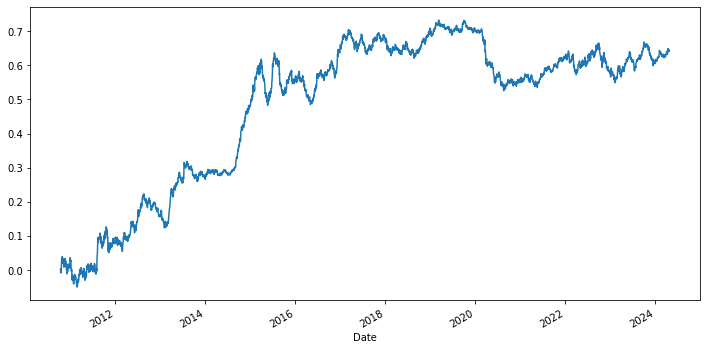

In [63]:
# To see how much we gain
(df.position * df.logRet).cumsum().plot(figsize=(12,6))

In [64]:
# Final total return
(df.position * df.logRet).sum()

0.6409570875590191

In [65]:
# Maximum drawdown
((df.position * df.logRet).cumsum().cummax() - (df.position * df.logRet).cumsum()).max()

0.20720640406170487

# Multilinear regression
In this case we don't use only the last time step to predict the next one, but also the n-time step before.

In [66]:
ticker = 'EURUSD=X'
start = '2010-10-10'
end = '2024-10-10'
interval = '1d'
df = yf.download(ticker, start=start, end=end, interval=interval)['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


In [67]:
df['logRet'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))

In [85]:
lags = 20
col_names = []

for lag in range(1,lags+1):
    col_name = 'logRet'+str(lag)
    col_names.append(col_name)
    df[col_name] = df['logRet'].shift(lag)
    
df.dropna(inplace=True)

In [86]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X=df[col_names], y=df.logRet.to_frame())

LinearRegression()

In [87]:
df['predict'] = lm.predict(df[col_names])

In [88]:
df['position'] = np.sign(df['predict'])

In [89]:
hits = np.sign(df.position * df.logRet)
hits.value_counts()
# +1 is when our prediction was right, -1 when it was wrong

 1.0    1862
-1.0    1612
 0.0      18
Name: count, dtype: int64

<Axes: xlabel='Date'>

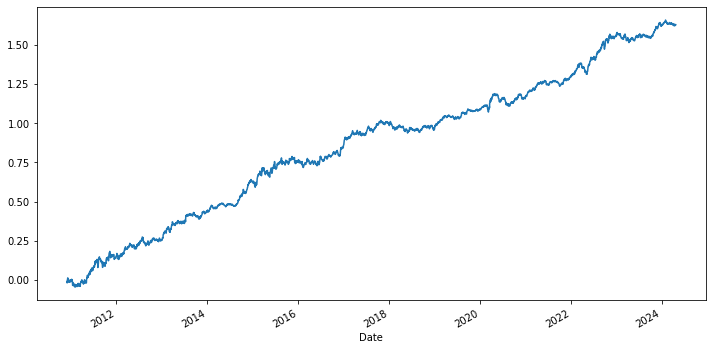

In [90]:
# To see how much we gain, the model looks more stable
(df.position * df.logRet).cumsum().plot(figsize=(12,6))

In [91]:
# Maximum drawdown
((df.position * df.logRet).cumsum().cummax() - (df.position * df.logRet).cumsum()).max()

0.08131236622274951

In [92]:
# Now we introduce the commissions
comm=0.0
spread=0.0008/df['Adj Close'].mean()

In [93]:
# Compute the number of trading positions change (for nearby days)
df['transactions'] = abs(df.position-df.position.shift(1))

<Axes: xlabel='Date'>

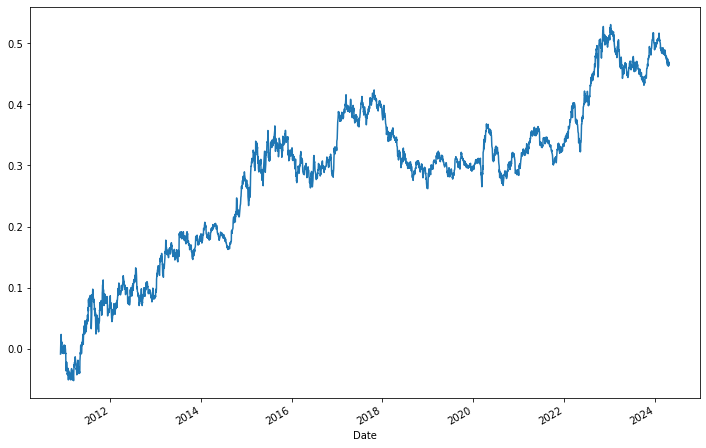

In [94]:
# Return - transaction costs
# we divide transaction costs by 2 because we computed transactions in such a way 
# that we have 0 or 2 value: 0 if the position didn't change -> we don't need to pay costs
# 2 if the position changed -> we go from long to short (or viceversa)
(df.position*df.logRet - df.transactions*(comm/2 + spread/2)).cumsum().plot(figsize=(12,8))

# Forward testing
We introduce the method *predict* to test the optimize model on new unseen data (test set).

In [220]:
class SMABacktester():
    '''Class for backtesting of simple linear regression trading strategies.'''
    
    def __init__(self, ticker, lags, start, end):
        '''
        Parameters
        ----------
        ticker: str
            String of the asset's ticker of Yahoo Finance
        lags: int
            Number for the n-lagged logRet
        start: str
            Starting date to get the data, format 'YYYY-MM-DD'
        end: str
            Ending date to get the data, format 'YYYY-MM-DD'
        '''
        self._ticker = ticker
        self.lags = lags
        self.col_names = []
        self._start = start
        self._end = end
        self.get_data()
        self.prepare_data()
        self.results = None
        self.linear_models = {}
        
    def get_data(self):
        '''
        Get the asset data using Yahoo Finance API, then compute the logReturn.
        '''
        df = yf.download(self._ticker, self._start, self._end)['Adj Close'].to_frame()
        df.dropna(inplace=True)
        df['logRet'] = np.log(df/df.shift(1))
        self.data = df
    
    def prepare_data(self):
        '''
        Add the n (lags) logRet columns to the dataframe
        '''
        self.col_names = []
        for lag in range(1,self.lags+1):
            col_name = 'logRet'+str(lag)
            self.col_names.append(col_name)
            self.data[col_name] = self.data['logRet'].shift(lag)
        
    def set_parameters(self, lags=None):
        '''
        Set a new window for short SMA, long SMA or both.
        
        Parameters
        ----------
        lags: int
            Number of logRet lag
        '''
        if lags is not None:
            self.lags = lags
            self.prepare_data()
            
    def test_strategy(self):
        '''
        Test linear regression trading strategy
        '''
        data = self.data.copy().dropna()
        lm = LinearRegression(fit_intercept=True)
        lm.fit(X=data[self.col_names], y=data.logRet.to_frame())
        self.linear_models[self.lags] = lm
        data['predict'] = lm.predict(data[self.col_names])
        data['position'] = np.sign(data['predict'])
        data['gain'] = data.position * data.logRet
        data.dropna(inplace=True)
        data['cumLogRet'] = data.logRet.cumsum()
        data['cumGain'] = data.gain.cumsum()
        # LR trading strategy performance
        performance = data.cumGain.iloc[-1]
        # Difference of performance of our trading strategy, compared to buy-and-hold
        outPerformance = data.cumGain.iloc[-1] - data.cumLogRet.iloc[-1]
        # Maximum drawdown value
        maxDrawdown = (data.cumGain.cummax() - data.cumGain).max()
        self.results = data
        # We are using logReturns, for this reason if we want the real return we must elevate
        # the difference with the exponential
        # With the exponantial we can know how much we gain from 1€ invested
        return round(performance, 6), round(outPerformance, 6), round(maxDrawdown, 6)
    
    def plot_results(self):
        '''
        Plot the cumulative log-return time series and the cumulative gain of our trading strategy
        '''
        assert self.results is not None, 'You must run test_strategy() before'
        
        title = '{}   lags = {}'.format(self._ticker, self.lags)
        self.results[['cumLogRet','cumGain']].plot(figsize=(14,8))
        plt.legend(fontsize=18)
        plt.title(title, fontsize=22)
        
    def optimize_parameters(self, logs_range):
        '''
        Find the best lags number that maximize the gain.
        '''
        combinations = list(range(*logs_range))
        performance_results = []
        for comb in combinations:
            self.set_parameters(lags = comb)
            performance_results.append(self.test_strategy()[0])
        bestPerformance = np.max(performance_results)
        bestParameters = combinations[np.argmax(performance_results)]
        
        self.set_parameters(bestParameters)
        
        allResults = pd.DataFrame(combinations, columns=['lags'])
        allResults['performance'] = performance_results
        self.resultsOverview = allResults
        return bestParameters, bestPerformance
    
    def predict(self, test_start, test_end):
        # Download test data
        data_test = yf.download(self._ticker, test_start, test_end)['Adj Close'].to_frame()
        data_test.dropna(inplace=True)
        data_test['logRet'] = np.log(data_test/data_test.shift(1))
        for lag in range(1,self.lags+1):
            col_name = 'logRet'+str(lag)
            data_test[col_name] = data_test['logRet'].shift(lag)
        data_test.dropna(inplace=True)
        lm = self.linear_models[self.lags]
        data_test['predict'] = lm.predict(data_test[self.col_names])
        data_test['position'] = np.sign(data_test['predict'])
        data_test['gain'] = data_test.position * data_test.logRet
        data_test.dropna(inplace=True)
        data_test['cumLogRet'] = data_test.logRet.cumsum()
        data_test['cumGain'] = data_test.gain.cumsum()
        # LR trading strategy performance
        performance = data_test.cumGain.iloc[-1]
        # Difference of performance of our trading strategy, compared to buy-and-hold
        outPerformance = data_test.cumGain.iloc[-1] - data_test.cumLogRet.iloc[-1]
        # Maximum drawdown value
        maxDrawdown = (data_test.cumGain.cummax() - data_test.cumGain).max()
        print('logReturn performance:',round(performance, 6))
        print('outperformance buy&hold:',round(outPerformance, 6))
        print('max drawdown:',round(maxDrawdown, 6))
        title = '{}   lags = {}'.format(self._ticker, self.lags)
        data_test[['cumLogRet','cumGain']].plot(figsize=(14,8))
        plt.legend(fontsize=18)
        plt.title(title, fontsize=22)

In [304]:
ticker = 'AAPL'
start = '2010-10-10'
end = '2022-10-10'
lags = 10
trainer = SMABacktester(ticker, lags, start, end)

[*********************100%%**********************]  1 of 1 completed


In [305]:
trainer.optimize_parameters((1,15))

(13, 3.941752)

In [306]:
trainer.test_strategy()

(3.927549, 1.202082, 0.402283)

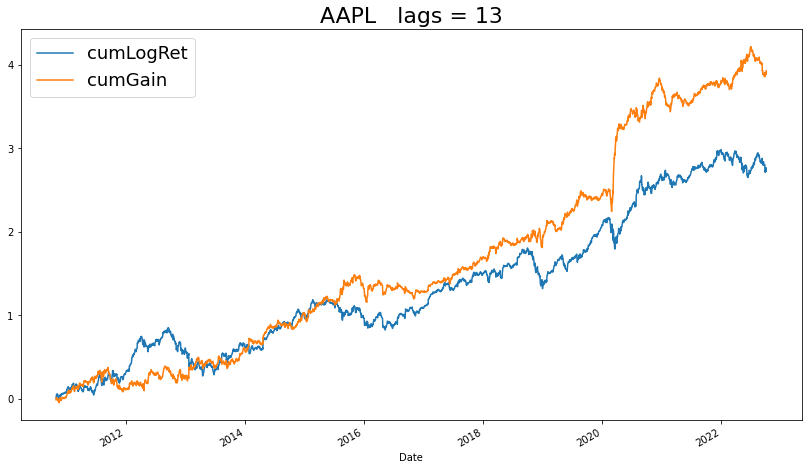

In [307]:
trainer.plot_results()

[*********************100%%**********************]  1 of 1 completed
logReturn performance: 0.496476
outperformance buy&hold: 0.402302
max drawdown: 0.106991


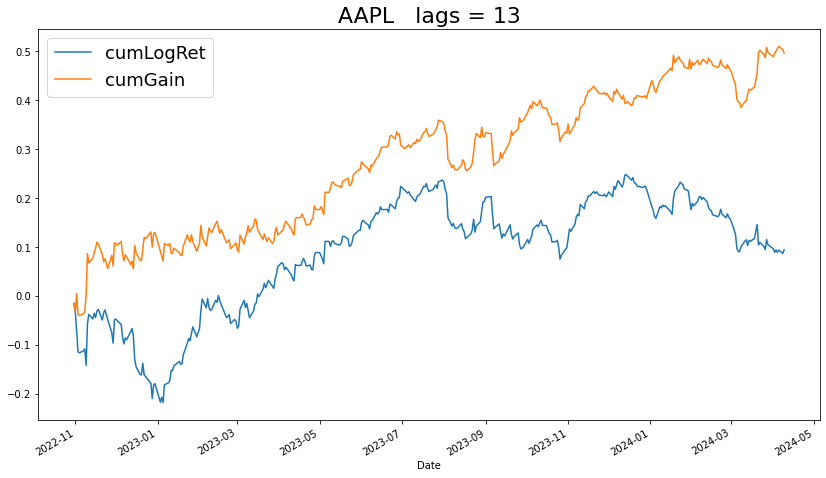

In [308]:
# Predict with new unseen data (test set)
start = '2022-10-11'
end = '2024-04-10'
trainer.predict(start, end)